# <span style='font-family:"Times New Roman"'> <span styel=''>**METRICS ANALYSIS**
*Emile Cohen*
    
 *April 2020*

**Goal:** In this notebook, we compute panels for specific metrics across all cancer types.

The notebook is composed of 2 parts:
   * **Subgroup Proportion**
   * **Number of aberrant chromosomes**
---

In [6]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
from itertools import cycle, islice

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [2]:
cancer_type = 'Ovarian Cancer'
mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')
# We remove INDETERMINATE and NaN tp53_cn_state samples
master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]

---
# Subgroup Proportion

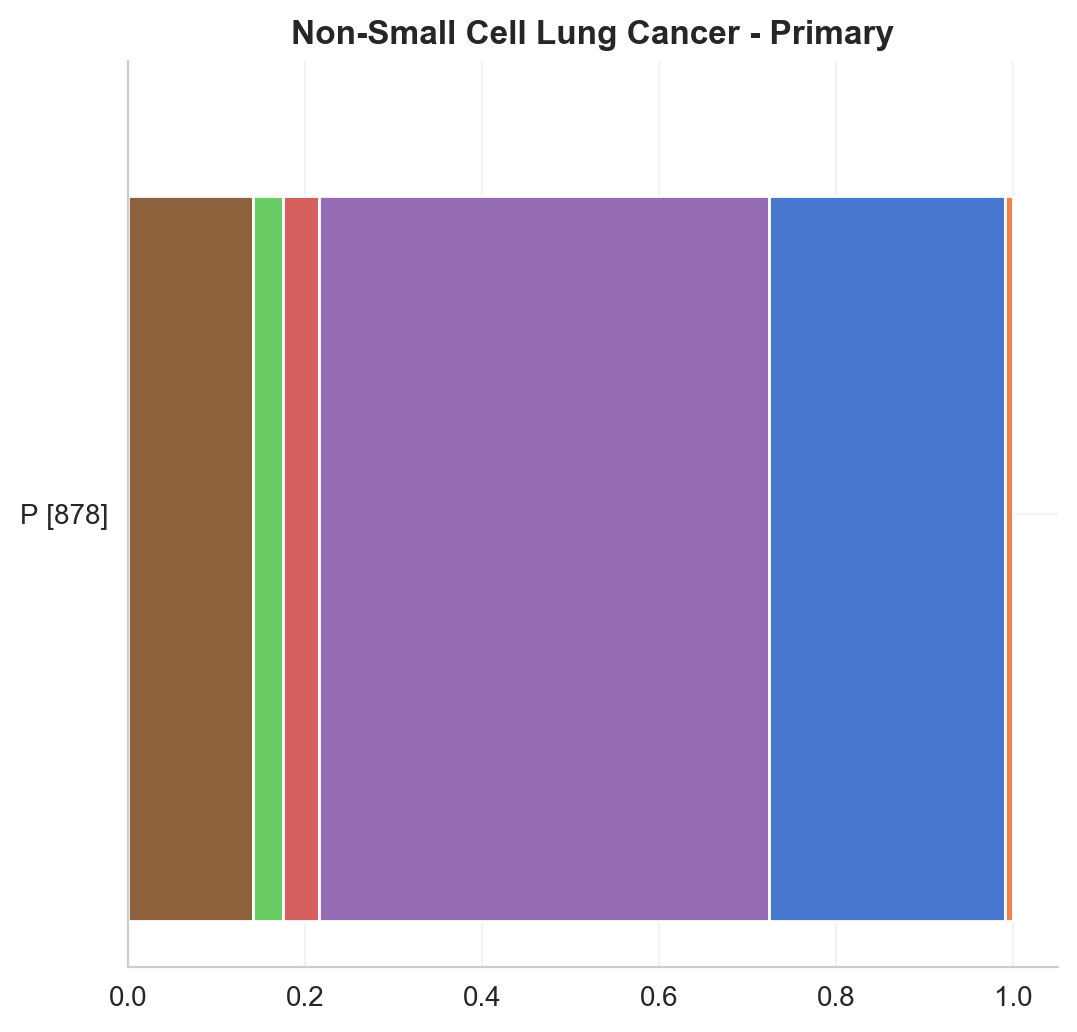

In [12]:
fig, ax = plt.subplots()

def plot_proportion(cancer_type: str, ax, title: str, prim_met: str):
    
    metrics='tp53_group'
    group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
    palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
    
    master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
    count_prim_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == prim_met], metrics, 'count_prim_met' + metrics)
    freq_prim_met = pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sort_values(by=['count_prim_met' + metrics], ascending=False)/ pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum()
    freq_prim_met.columns=[prim_met]
    freq_prim_met = freq_prim_met.reindex(group_list)
    freq = pd.concat([freq_prim, freq_met], axis=1)

    freq_prim_met.T.plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=palette_list)
    ax.set_title(title, weight = 'bold', fontsize=12)
    ax.legend_.remove()
    ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([ 'P ' + str(pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum().values)]))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for container in ax.containers:
        for i, child in enumerate(container.get_children()):
            child.set_y(child.get_y() - 0.2)
            child.set_height(0.8)

    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
        
plot_proportion(cancer_type='Non-Small Cell Lung Cancer', 
                ax=ax, 
                title='Non-Small Cell Lung Cancer - Primary', 
                prim_met='Metastasis')

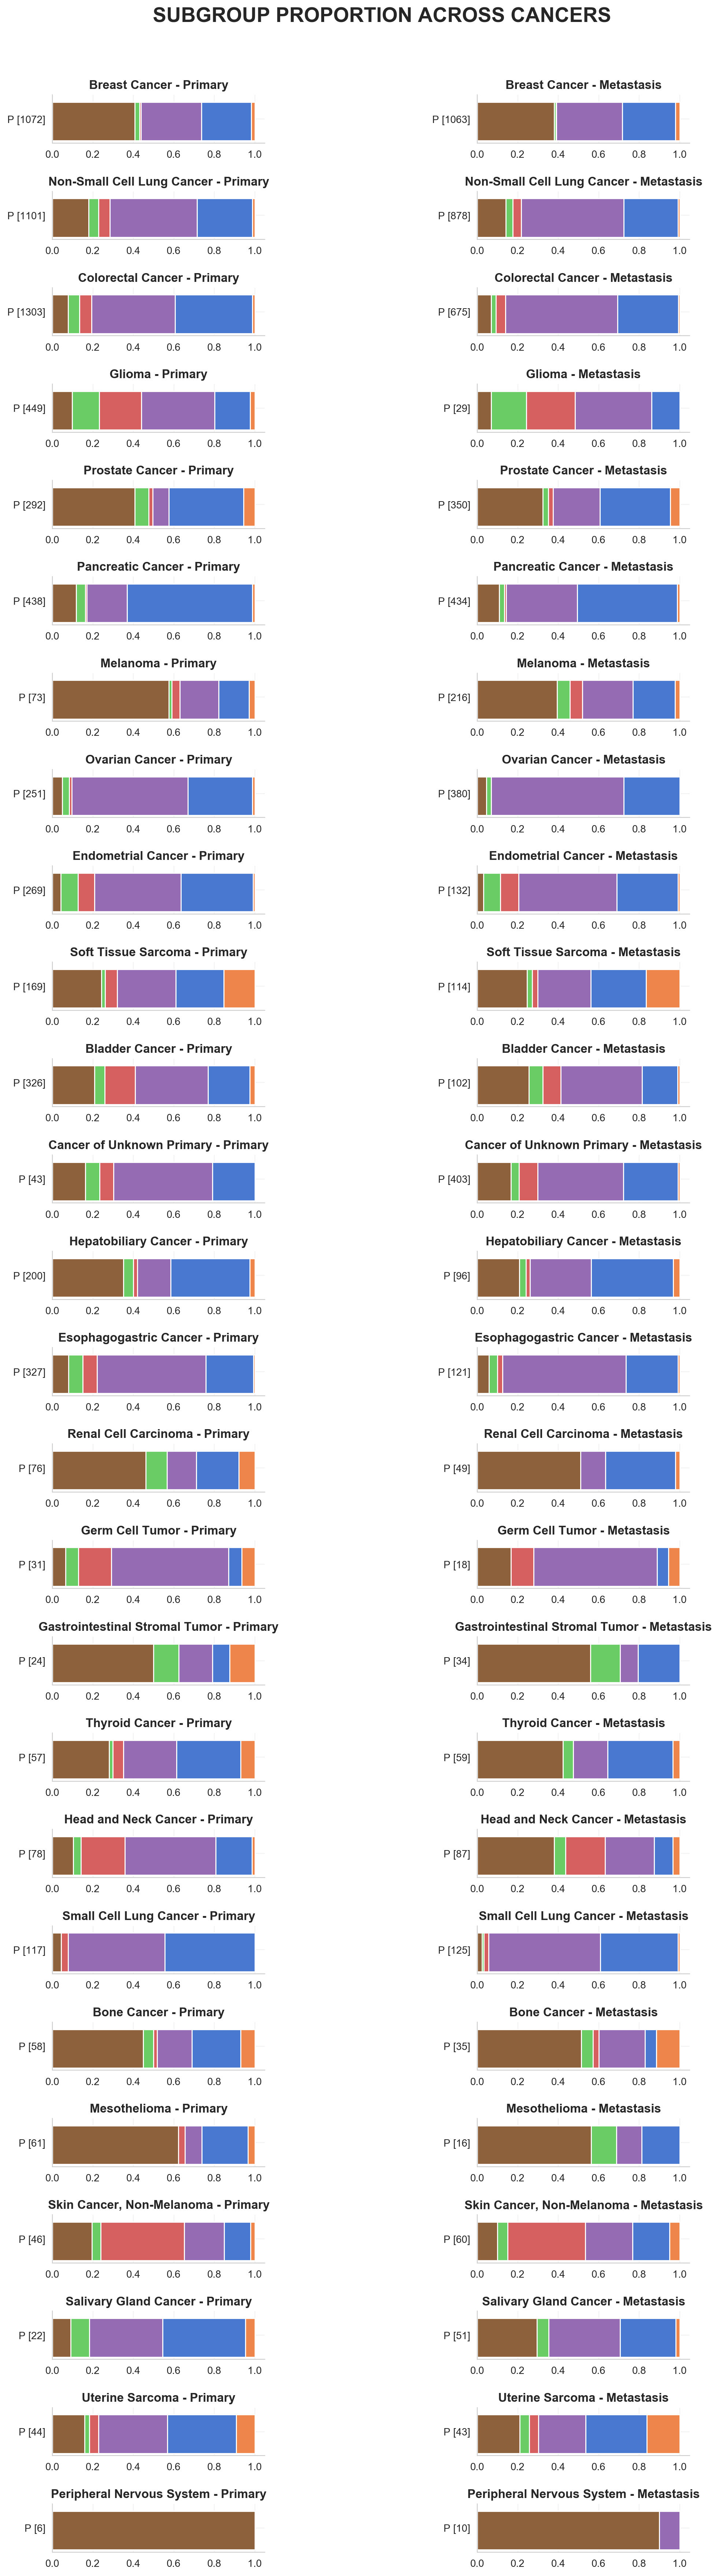

In [32]:
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)

fig = plt.figure(figsize=(10,40))
outer = gridspec.GridSpec(nrows=3*len(cancer_list), ncols=2)

for i, cancer_type in zip(list(range(3*len(cancer_list))[::3]),cancer_list):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[i:(i+2), :2],wspace=1, hspace=0)
    ax_prim = plt.Subplot(fig, inner[0])
    ax_met = plt.Subplot(fig, inner[1])
    plot_proportion(cancer_type=cancer_type, ax=ax_prim, title=cancer_type + ' - Primary', prim_met='Primary')
    plot_proportion(cancer_type=cancer_type, ax=ax_met, title=cancer_type + ' - Metastasis', prim_met='Metastasis')
    
    fig.add_subplot(ax_prim)
    fig.add_subplot(ax_met)

fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.95, wspace=1, hspace=1)
fig.suptitle('SUBGROUP PROPORTION ACROSS CANCERS', fontsize=20,fontweight='bold')
fig.savefig('./metrics_summaries/subgroup_proportions.pdf', format='pdf')

---
# Number of aberrant chromosomes

In [51]:
def style(ax1):
    for i, artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor('black')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i * 6, i * 6 + 6):
            line = ax1.lines[j]
            line.set_color('black')
            line.set_mfc('None')
            line.set_mec('None')

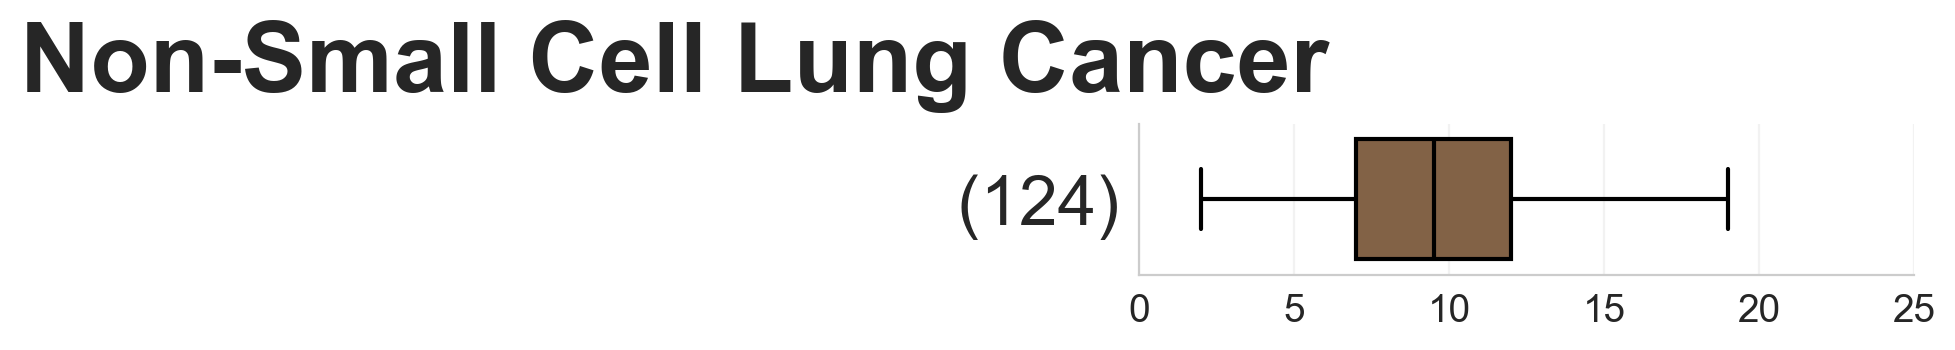

In [92]:
group = '0_HETLOSS'
metrics = 'chr_affected'
cancer_type = 'Non-Small Cell Lung Cancer'
first=False
title = cancer_type
prim_met='Metastasis'

fig, ax = plt.subplots(figsize=(5,1))

def plot_aberrant_chromosomes(cancer_type: str, metrics: str, ax, group: str, title: str, prim_met: str, first=True, xlim:int=25):

    group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
    palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]

    master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
    master_cancer_group = master_cancer[master_cancer['tp53_group'] == group][master_cancer['Sample_Type'] == prim_met]
    

    h=sns.boxplot(y="tp53_group",
                  x=metrics,
                  data=master_cancer_group,
                  ax=ax,
                  color=palette_list[group_list.index(group)])

    style(ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 


    ax.set_xlim(0, xlim)
    if first:
        ax.set_yticklabels([group + ' (' + str(master_cancer_group.shape[0]) + ')'], fontsize=17)
    else: 
        ax.set_yticklabels([' (' + str(master_cancer_group.shape[0])+ ')'], fontsize=25)

    ax.set_title(title, fontsize=35, weight='bold', y=1.1, x = -0.6)
    
plot_aberrant_chromosomes(cancer_type=cancer_type, 
                          metrics=metrics, 
                          group=group, 
                          ax=ax,
                          title=title, 
                          prim_met=prim_met, 
                          first=False, 
                          xlim=25)

## Primary Samples

In [ ]:
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)

prim_met = 'Metastasis'
metrics = 'mutation

In [128]:
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)

prim_met = 'Metastasis'
metrics = 'mutation_count'

fig = plt.figure(figsize=(50,68))
outer = gridspec.GridSpec(nrows=3*len(cancer_list)+8, ncols=6)

inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[0:2, :6],wspace=0.2, hspace=0)
ax = plt.Subplot(fig, inner[0])
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
palette = dict(zip(group_list, palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax.legend(handles=handles, fontsize=30, loc='centered')
# Get current axes object and turn off axis
ax.set_axis_off()

fig.add_subplot(ax)


for i, cancer_type in zip(list(range(3*len(cancer_list))[::3]),cancer_list):
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=6, subplot_spec=outer[i+8:(i+2)+8, :6],wspace=0.2, hspace=0)

    ax_hetloss = plt.Subplot(fig, inner[0])
    ax_wt = plt.Subplot(fig, inner[1])
    ax_mut = plt.Subplot(fig, inner[2])
    ax_cnloh = plt.Subplot(fig, inner[3])
    ax_loss = plt.Subplot(fig, inner[4])
    ax_homdel = plt.Subplot(fig, inner[5])
    #if i == 0 : first = True
    first = False
    try:
        plot_aberrant_chromosomes(cancer_type=cancer_type, 
                                  metrics=metrics, 
                                  group='0_HETLOSS', 
                                  ax=ax_hetloss,
                                  title='', 
                                  prim_met=prim_met, 
                                  first=first, 
                                  xlim=50)
    except: pass

    try:
        plot_aberrant_chromosomes(cancer_type=cancer_type, 
                                  metrics=metrics, 
                                  group='1_WILD_TYPE', 
                                  ax=ax_wt,
                                  title='', 
                                  prim_met=prim_met, 
                                  first=first, 
                                  xlim=50)
    except: pass

    try:
        plot_aberrant_chromosomes(cancer_type=cancer_type, 
                                  metrics=metrics, 
                                  group='>1muts', 
                                  ax=ax_mut,
                                  title='', 
                                  prim_met=prim_met, 
                                  first=first, 
                                  xlim=50)
    except: pass

    try:
        plot_aberrant_chromosomes(cancer_type=cancer_type, 
                                  metrics=metrics, 
                                  group='>=1_cnLOH', 
                                  ax=ax_cnloh,
                                  title=cancer_type, 
                                  prim_met=prim_met, 
                                  first=first, 
                                  xlim=50)
    except: pass

    try:
        plot_aberrant_chromosomes(cancer_type=cancer_type, 
                                  metrics=metrics, 
                                  group='>=1_LOSS', 
                                  ax=ax_loss,
                                  title='', 
                                  prim_met=prim_met, 
                                  first=first, 
                                  xlim=50)
    except: pass

    try:
        plot_aberrant_chromosomes(cancer_type=cancer_type, 
                                  metrics=metrics, 
                                  group='HOMDEL', 
                                  ax=ax_homdel,
                                  title='', 
                                  prim_met=prim_met, 
                                  first=first, 
                                  xlim=50)
    except: pass


    fig.add_subplot(ax_hetloss)
    fig.add_subplot(ax_wt)
    fig.add_subplot(ax_mut)
    fig.add_subplot(ax_cnloh)
    fig.add_subplot(ax_loss)
    fig.add_subplot(ax_homdel)

fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.965, wspace=1, hspace=2)
fig.suptitle('MUTATION COUNT -  METASTATIC SAMPLES', fontsize=50,fontweight='bold')
fig.savefig('./metrics_summaries/mutation_count_metastasis.pdf', format='pdf')

## Metastatic Samples

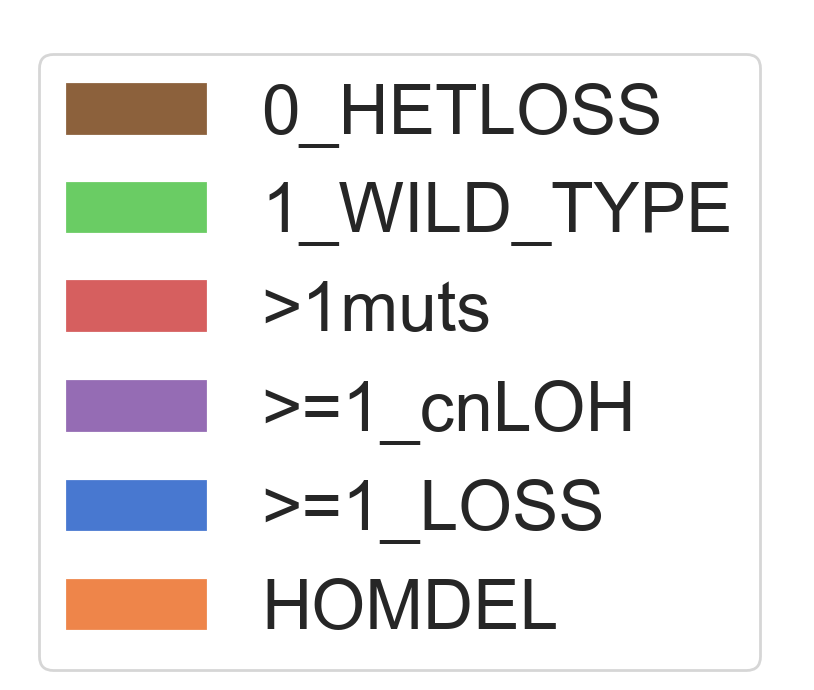

In [115]:
fig, ax = plt.subplots(figsize=(5,1))
# Create a color palette
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
palette = dict(zip(group_list, palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax.legend(handles=handles, fontsize=25, loc='centered')
# Get current axes object and turn off axis
ax.set_axis_off()
plt.show()